In [1]:
import os
import glob
from datetime import datetime
from collections import defaultdict

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('error', category=UserWarning)

In [2]:
rrdp_dir = '../SAGE_RRDP/s_rrdp_jan21'
coll_dir = './collocated'

rrdp_files = sorted(glob.glob(os.path.join(rrdp_dir, '*_N.nc')))
rrdp_dates = [datetime.strptime(os.path.basename(f).split('_')[0], '%Y%m%d') for f in rrdp_files]
coll_files = [f'{coll_dir}/{d.strftime("%Y")}/lagrangian_{d.strftime("%Y%m%d")}.nc' for d in rrdp_dates]
rrdp_coll_date_files = [(date, rf, cf) for date, rf, cf in zip(rrdp_dates, rrdp_files, coll_files) if os.path.exists(cf)]
len(rrdp_coll_date_files), rrdp_coll_date_files[0]

(2129,
 (datetime.datetime(2012, 1, 2, 0, 0),
  '../SAGE_RRDP/s_rrdp_jan21/20120102_N.nc',
  './collocated/2012/lagrangian_20120102.nc'))

In [3]:
rrdp_icetypes = ['icetype_matches', 'NIC_dom_icetype', 'autoDMI_dom_icetype', 'AARI_dom_icetype', 'CIS_dom_icetype']
lagr_algos = ['lm', 'newdc', 'nsidc']

min_size = 2000
scores = defaultdict(list)
comas = defaultdict(list)
for date, rf, cf in tqdm(rrdp_coll_date_files):
    ice_type = {}
    with xr.open_dataset(rf) as ds:
        for rrdp_icetype in rrdp_icetypes:
            if rrdp_icetype in ds:
                ice_type[rrdp_icetype] = ds[rrdp_icetype][0].values
    
    with xr.open_dataset(cf) as ds:
        for lagr_algo in lagr_algos:
            ice_type[lagr_algo] = ds[f'{lagr_algo}_ice_type'][0].values
        
    # convert to FYI/MYI only
    for name in ice_type:
        ice_type[name][ice_type[name] == 1] = 2
        ice_type[name][ice_type[name] == 3] = 4
    
    coll_mask = np.isfinite(ice_type['lm']) & (ice_type['lm'] > 0) & (ice_type['newdc'] > 0) & (ice_type['nsidc'] > 0)
    for name in rrdp_icetypes:
        if name not in ice_type:
            continue
        rrdp_mask = np.isfinite(ice_type[name]) & (ice_type[name] > 0)
        comm_mask = coll_mask & rrdp_mask

        if np.sum(comm_mask) < min_size:
            continue

        coma_vec = []
        scores_vec = []
        for algo in lagr_algos:
            coma = confusion_matrix(
                ice_type[name][comm_mask],
                ice_type[algo][comm_mask], labels=[2, 4])
            if np.any(np.sum(coma, axis=1) == 0):
                continue
            coma_normalized = coma.astype('float') / coma.sum(axis=1)[:, np.newaxis]
            accuracy = np.trace(coma) / np.sum(coma)
            balanced_accuracy = np.mean(np.diag(coma_normalized))
            coma_vec.append(coma)
            scores_vec.extend([accuracy, balanced_accuracy])
        
        if len(coma_vec) < len(lagr_algos):
            continue
        comas[name].append(coma_vec)
        scores[name].append((date, *scores_vec, np.sum(comm_mask)))



100%|██████████| 2129/2129 [02:31<00:00, 14.06it/s]


In [4]:
for name in scores:
    scores[name] = pd.DataFrame(scores[name], columns=['date', 'acc_lm', 'bac_lm', 'acc_newdc', 'bac_newdc', 'acc_nsidc', 'bac_nsidc', 'count'])
    scores[name].set_index('date', inplace=True)
    comas[name] = np.array(comas[name])  # shape (time, 4, 2, 2)

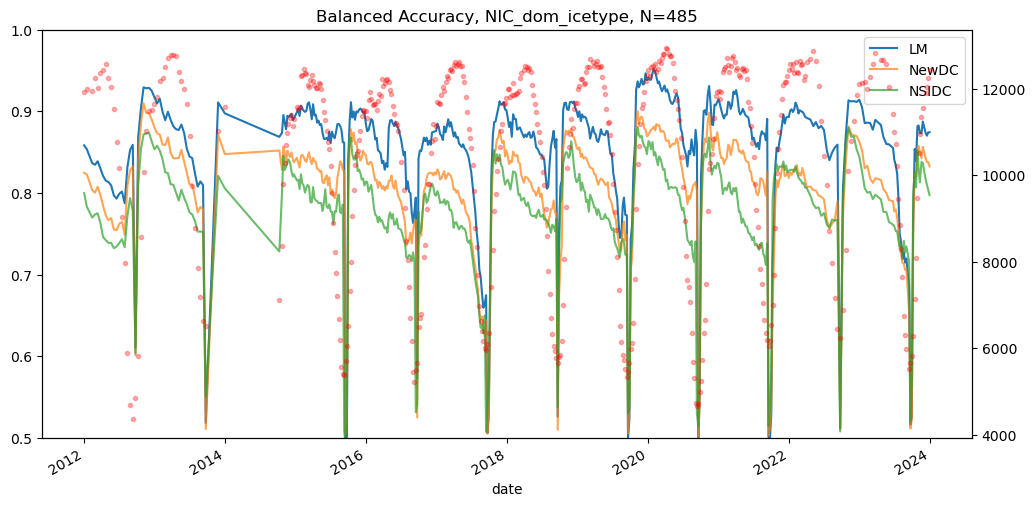

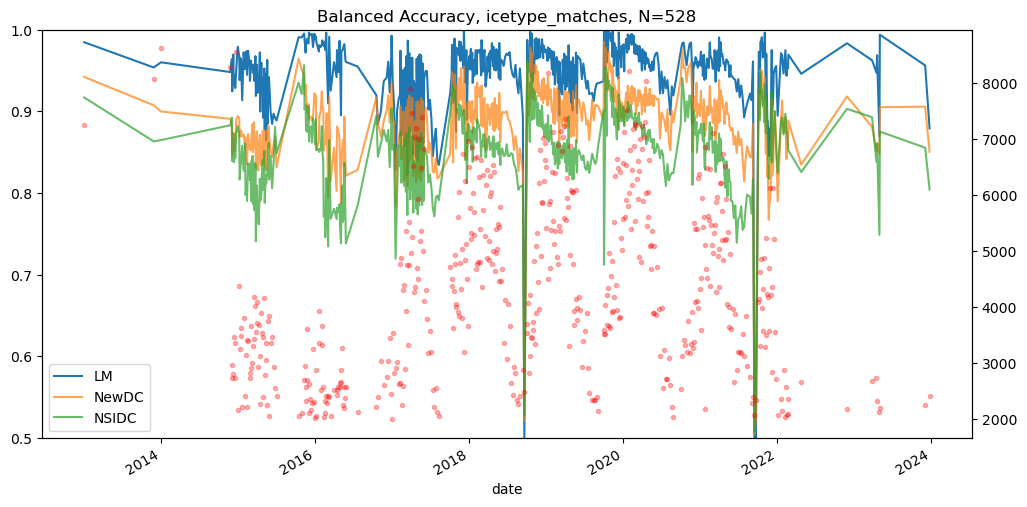

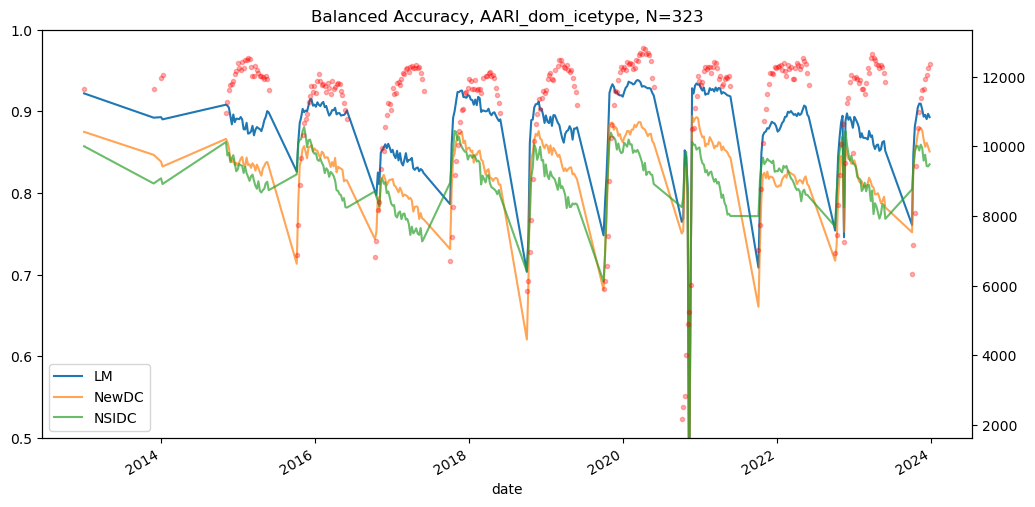

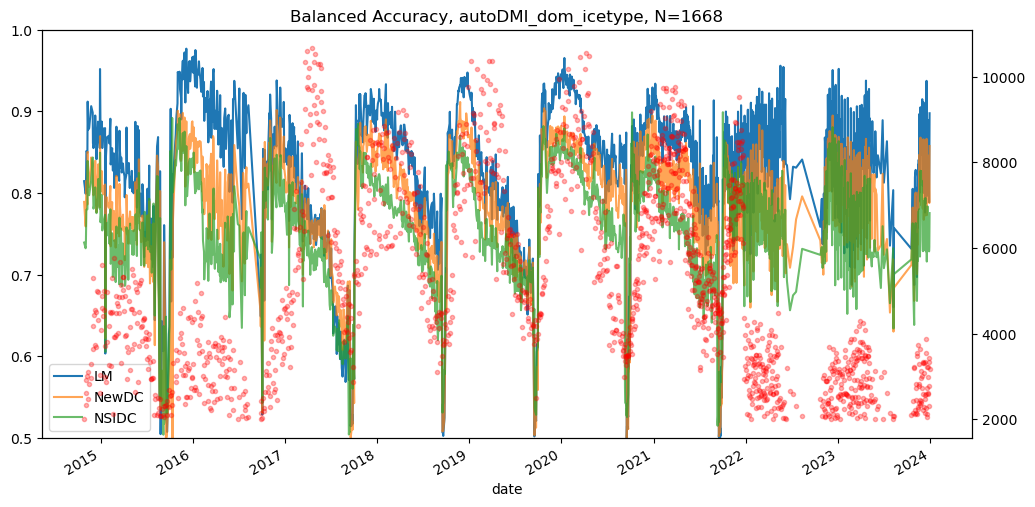

In [5]:
warnings.filterwarnings('ignore', category=UserWarning)

for name in scores:
    fig = plt.figure(figsize=(12, 6))
    scores[name]['bac_lm'].plot(label='LM')
    scores[name]['bac_newdc'].plot(label='NewDC', alpha=0.7)
    scores[name]['bac_nsidc'].plot(label='NSIDC', alpha=0.7)
    plt.ylim(0.5, 1)
    plt.legend()
    ax2 = plt.twinx()
    ax2.plot(scores[name].index, scores[name]['count'].values, 'r.', label='Count', alpha=0.3)
    #plt.xlim(datetime(2019,9,15), datetime(2020,12,31))
    plt.title(f'Balanced Accuracy, {name}, N={scores[name].shape[0]}')
    plt.show()
    

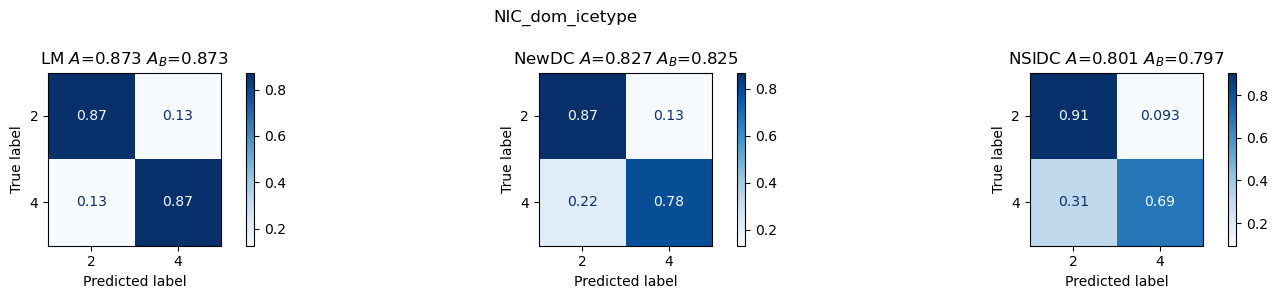

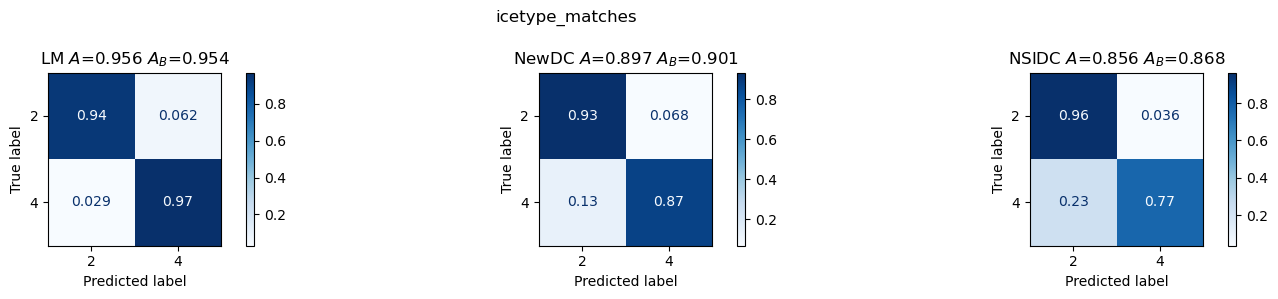

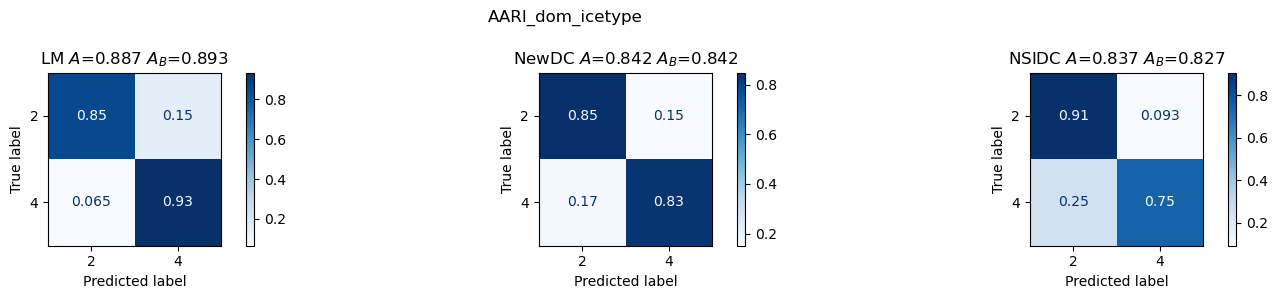

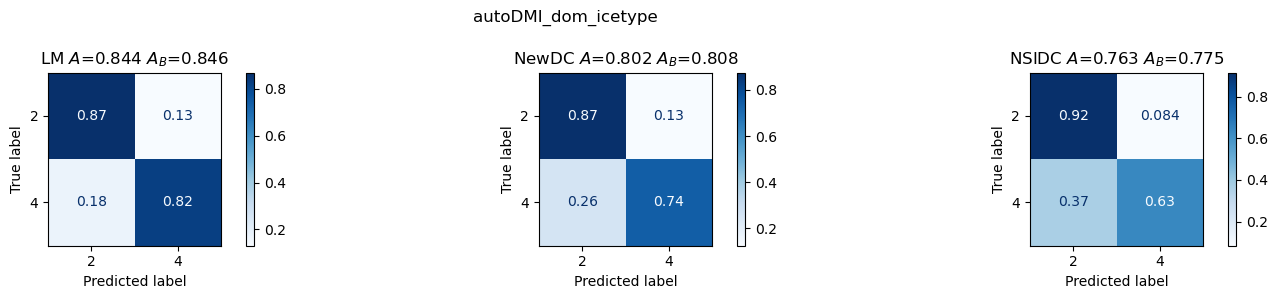

In [6]:
for name in comas:
    alg_labels = ['LM', 'NewDC', 'NSIDC']
    fig, axs = plt.subplots(1, 3, figsize=(15,3))
    for i in range(3):
        coma = comas[name][:, i].sum(axis=0)
        coma_normalized = coma.astype('float') / coma.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=coma_normalized, display_labels=[2, 4])
        disp.plot(ax=axs[i], cmap=plt.cm.Blues)
        accuracy = np.trace(coma) / np.sum(coma)
        balanced_accuracy = np.mean(np.diag(coma_normalized))
        axs[i].set_title(f'{alg_labels[i]} $A$={accuracy:0.3f} $A_B$={balanced_accuracy:0.3f}')
    fig.suptitle(name)
    plt.tight_layout()
    plt.show()

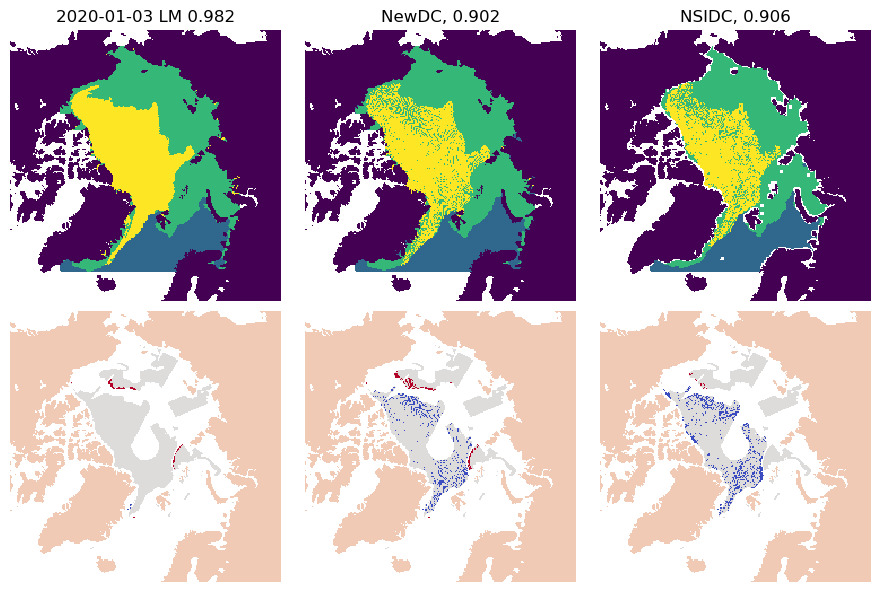

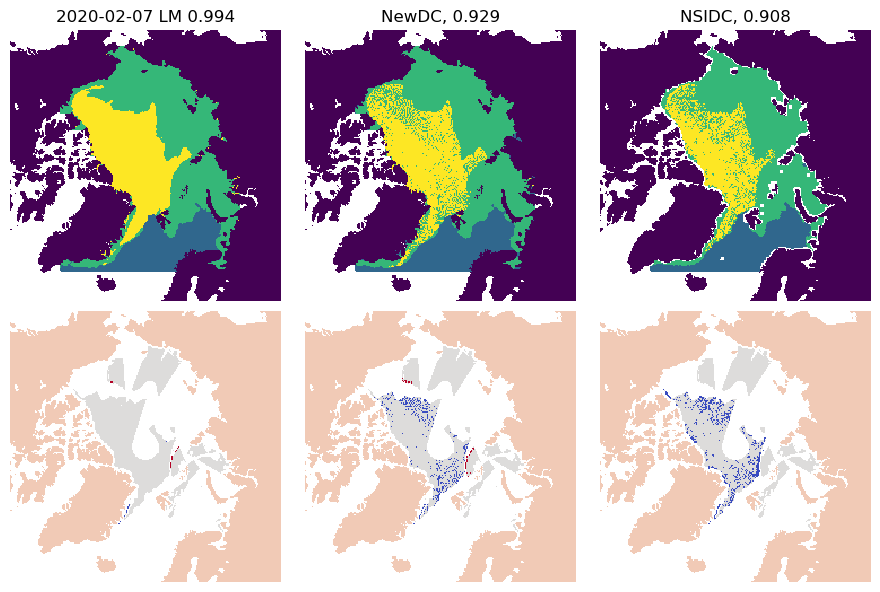

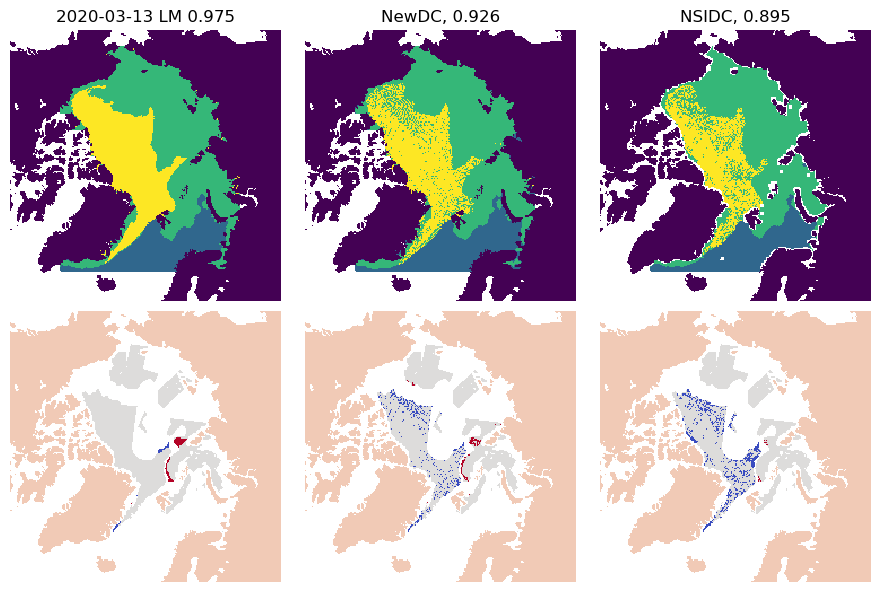

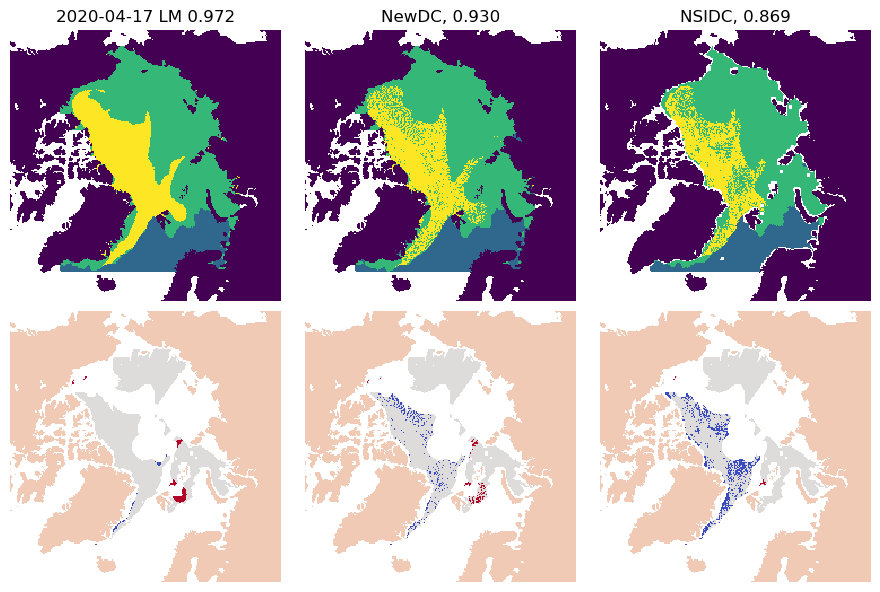

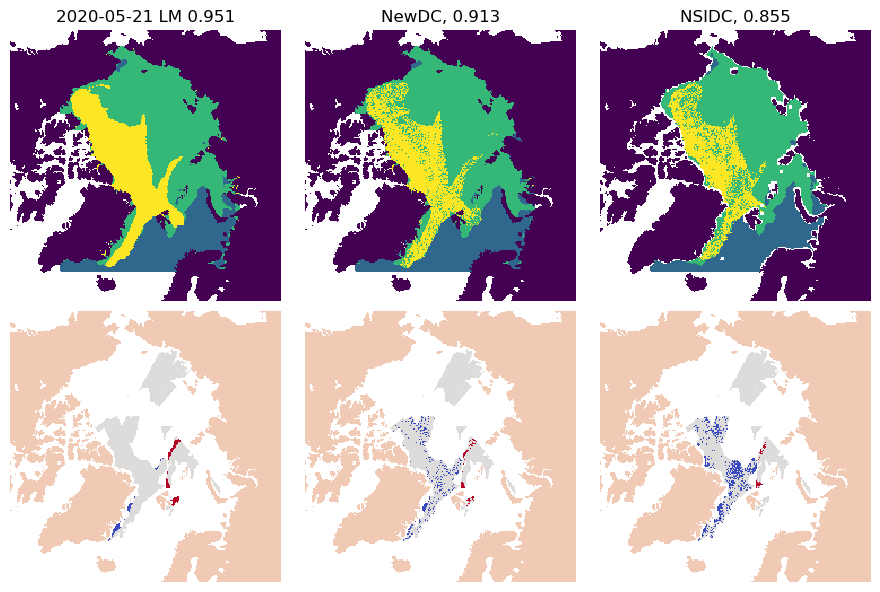

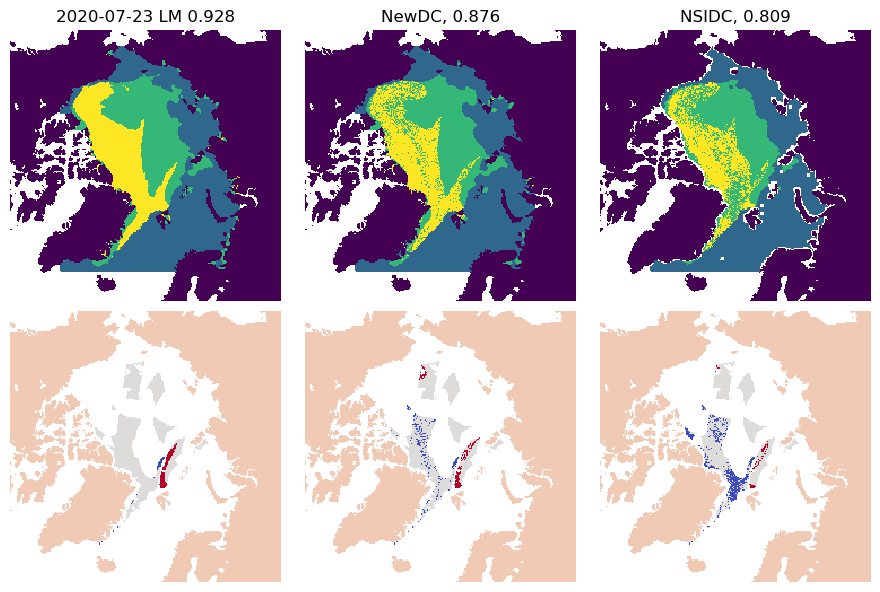

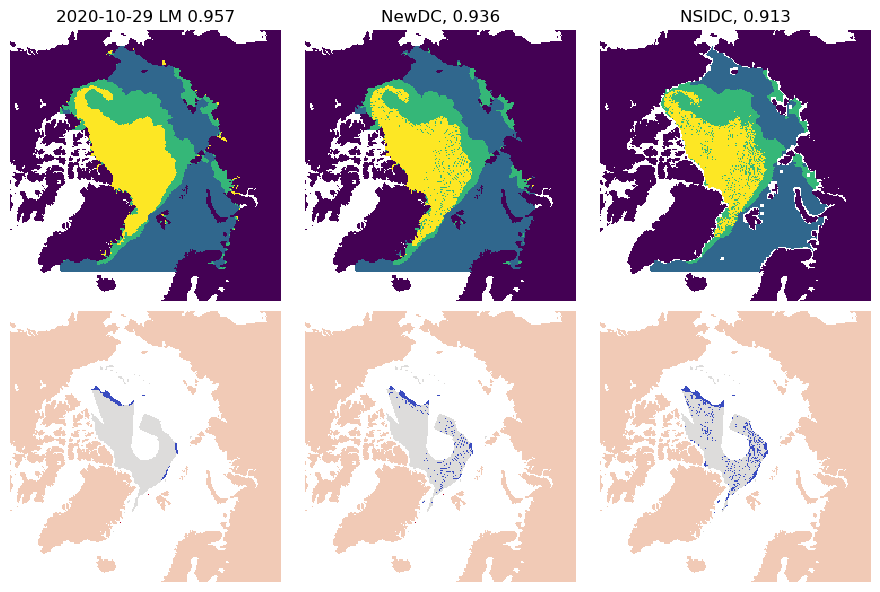

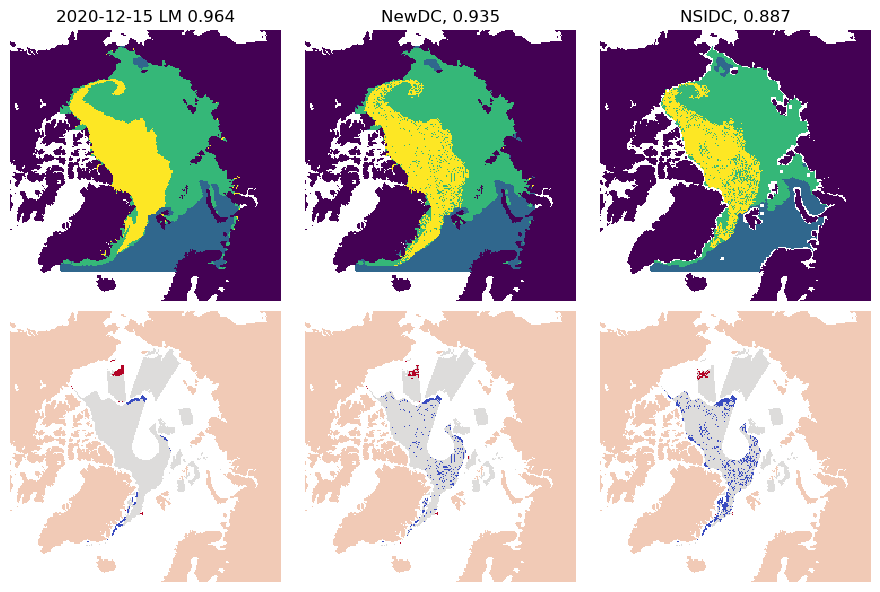

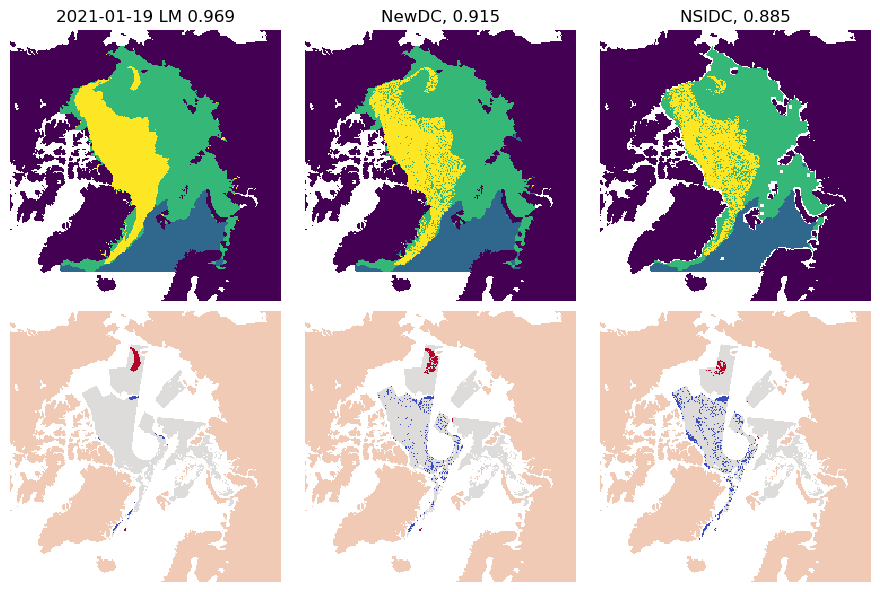

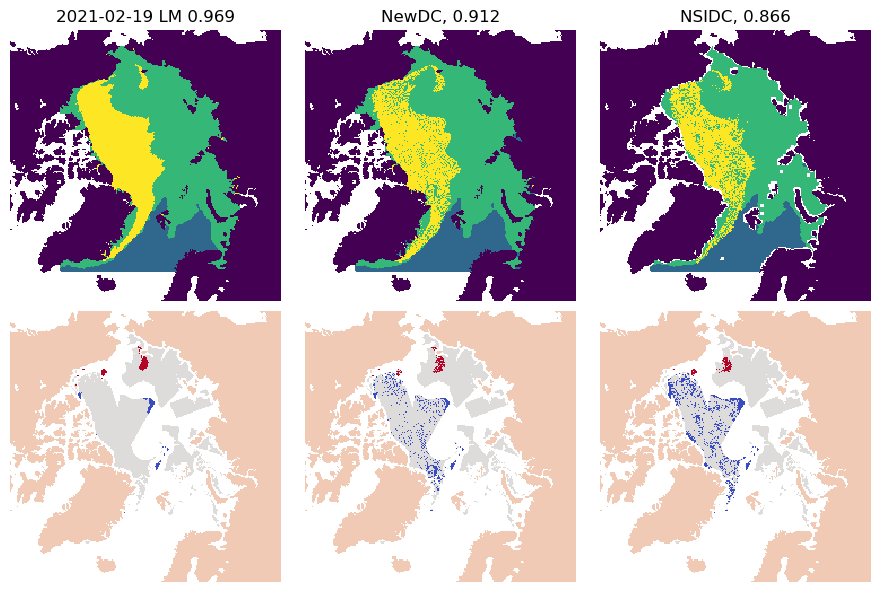

In [7]:
# rrdp_dates, rrdp_files, coll_files
plot_date_start = datetime(2020, 1, 1)
plot_dates = [d for d in scores['icetype_matches'].index if d >= plot_date_start][:100:10]
for plot_date in plot_dates:
    rf = rrdp_files[rrdp_dates.index(plot_date)]
    cf = coll_files[rrdp_dates.index(plot_date)]
    with xr.open_dataset(rf) as ds:
        icetype_matches = ds['icetype_matches'][0].values
    with xr.open_dataset(cf) as ds:
        lm_ice_type = ds['lm_ice_type'][0].values
        newdc_ice_type = ds['newdc_ice_type'][0].values
        nsidc_ice_type = ds['nsidc_ice_type'][0].values
        
    # convert to FYI/MYI only
    icetype_matches[icetype_matches == 1] = 2
    icetype_matches[icetype_matches == 3] = 4
    lm_ice_type[lm_ice_type == 3] = 4
    newdc_ice_type[newdc_ice_type == 3] = 4
    nsidc_ice_type[nsidc_ice_type == 3] = 4


    fig, axs = plt.subplots(2, 3, figsize=(9,6))    
    im0 = axs[0,0].imshow(lm_ice_type, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
    axs[0,0].set_title(f'{plot_date.strftime("%Y-%m-%d")} LM {scores['icetype_matches'].loc[plot_date].bac_lm:0.3f}')
    im1 = axs[0,1].imshow(newdc_ice_type, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
    axs[0,1].set_title(f'NewDC, {scores["icetype_matches"].loc[plot_date].bac_newdc:0.3f}')
    im2 = axs[0,2].imshow(nsidc_ice_type, vmin=-2, vmax=4, cmap='viridis', interpolation='none')
    axs[0,2].set_title(f'NSIDC, {scores["icetype_matches"].loc[plot_date].bac_nsidc:0.3f}')
    
    coll_mask = np.isfinite(lm_ice_type) & (lm_ice_type > 0) & (newdc_ice_type > 0) & (nsidc_ice_type > 0)
    rrdp_mask = np.isfinite(icetype_matches) & (icetype_matches > 0)
    comm_mask = coll_mask & rrdp_mask
    landmask = lm_ice_type == -2
    lm_ice_type[~comm_mask] = np.nan
    newdc_ice_type[~comm_mask] = np.nan
    nsidc_ice_type[~comm_mask] = np.nan
    lm_ice_type[landmask] = -2
    newdc_ice_type[landmask] = -2
    nsidc_ice_type[landmask] = -2
    icetype_matches[landmask] = -2.4

    im3 = axs[1,0].imshow(lm_ice_type - icetype_matches, vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
    im4 = axs[1,1].imshow(newdc_ice_type - icetype_matches, vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
    im5 = axs[1,2].imshow(nsidc_ice_type - icetype_matches, vmin=-2, vmax=2, cmap='coolwarm', interpolation='none')
    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
